In [1]:
import requests
from bs4 import BeautifulSoup
from os.path  import basename

In [2]:
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
page = 'https://www.transfermarkt.co.uk/laliga/startseite/wettbewerb/ES1'
tree = requests.get(page, headers = headers)
soup = BeautifulSoup(tree.content, 'html.parser')

#Create an empty list to assign these values to
teamLinks = []
teams = set()
#Extract all links with the correct CSS selector
links = soup.select("a.vereinprofil_tooltip")

for name in soup.find_all("td", class_="zentriert no-border-rechts"):
    
    teams.add(name.find("a")["title"])
    
    tempLink = "https://www.transfermarkt.co.uk"
    if "startseite" in name.find("a")["href"]:
        array = name.find("a")["href"].split("/")[:5]
        for i, val in enumerate(array):
            if i < 5:
                tempLink += array[i] + "/"
        teamLinks.append(tempLink)
    

_team_links = []
print("NUMBER OF TEAMS:", len(teams), "\n")
# for team, link in zip(teams, teamLinks): 
#     print(team)
#     print(link, '\n')
#     _team_links.append((team.lower(), link))

NUMBER OF TEAMS: 20 



In [3]:
def getSalaries():
    page = 'https://soccerprime.com/fc-barcelona-player-salaries/'
    tree = requests.get(page, headers = headers)
    soup = BeautifulSoup(tree.content, 'html.parser')
    table = soup.find_all("table")
    playerSalaries = {}

    for index, i in enumerate(table):
        counter = 0
        temp = i.find_all("td")
        while counter < len(temp):
            name = str(temp[counter])[len("<td>"):-len("<td>")-1]
            counter += 2
            salary = str(temp[counter])[len("<td>"):-len("<td>")-1]
            counter += 1
            playerSalaries[name] = salary

    return playerSalaries

In [4]:
import pandas as pd
import numpy as np

def scrape_data(page):

    headers = {'User-Agent':
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
    pageTree = requests.get(page, headers = headers)
    pageSoup = BeautifulSoup(pageTree.content, 'html.parser')

    # --------------------------------------------------------------------------

    PlayersList = []
    AgeList = []
    PositionsList = []
    NationList = []
    ValuesList = []
    PlayersLink = []
    Attr1 = []
    Attr2 = []
    Attr3 = []
    Attr4 = []

    # --------------------------------------------------------------------------

    Players = pageSoup.find_all("img", {"class": "bilderrahmen-fixed lazy lazy"})
    
    Age = pageSoup.find_all("td", {"class": "zentriert"})

    Positions = pageSoup.find_all("td", {
          "class": [
                    "zentriert rueckennummer bg_Torwart",
                    "zentriert rueckennummer bg_Abwehr",
                    "zentriert rueckennummer bg_Mittelfeld",
                    "zentriert rueckennummer bg_Sturm"
          ]
      })

    Nationality = pageSoup.find_all("td", {"class": "zentriert"})

    Values = pageSoup.find_all("td", {"class": "rechts hauptlink"})

    for i in range(0,len(Players)): PlayersList.append(str(Players[i]).split('" class', 1)[0].split('<img alt="',1)[1])
    for i in range(1,(len(Players)*3),3): AgeList.append(int(str(Age[i]).split("(",1)[1].split(")",1)[0]))
    for i in range(0,len(Positions)): PositionsList.append(str(Positions[i]).split('title="',1)[1].split('"><div')[0].lower())
    for i in range(2,(len(Players)*3),3): NationList.append(str(Nationality[i]).split('title="',1)[1].split('"/',1)[0].lower())
    for i in range(0,len(Values)): ValuesList.append(Values[i].text)

    # --------------------------------------------------------------------------
    
    playershtml = pageSoup.find_all("td", {"class": "hauptlink"})
    players = int(str(pageSoup.find("span", {"class" : "dataValue"}))[len("<span class='dataValue'>"): -len("</span>")])
    
    for i, v in enumerate(playershtml[:(2*players)]):
        if i % 2 != 0: continue
            
        array = v.find("a")["href"].split("/")
        linkTemp = "https://www.transfermarkt.co.uk"
        for i,v in enumerate(array):
            if i == 2:
                linkTemp += "leistungsdatendetails/"
            else:
                linkTemp += v + "/"
        PlayersLink.append(linkTemp + "plus/0?saison=ges")
        
    salaries = getSalaries()
    
    # --------------------------------------------------------------------------
    
    for index, i in enumerate(PlayersLink):
        pageTree = requests.get(i, headers = headers)
        pageSoup = BeautifulSoup(pageTree.content, 'html.parser')
        temp = pageSoup.find("tfoot").find_all("td", {"class": ["zentriert", "rechts"]})
        
        if index < 3: 
            TotalGames = str(temp[2])[len('<td class="zentriert">'):-len('</td>')]
            GoalsConceeded = str(temp[5])[len('<td class="zentriert">'):-len('</td>')]
            Cleansheets = str(temp[6])[len('<td class="zentriert">'):-len('</td>')]
            minutes = str(temp[7])[len('<td class="rechts">'):-len('</td>')]

            Goals = GoalsConceeded
            Assists = Cleansheets

        else:
            TotalGames = str(temp[2])[len('<td class="zentriert">'):-len('</td>')]
            Goals = str(temp[3])[len('<td class="zentriert">'):-len('</td>')]
            Assists = str(temp[4])[len('<td class="zentriert">'):-len('</td>')]
            minutes = str(temp[6])[len('<td class="rechts">'):-len('</td>')]
            
        
        if TotalGames.isdigit(): Attr1.append(int(TotalGames))
        else: Attr1.append(np.nan)

        if Goals.isdigit(): Attr2.append(int(Goals))
        else: Attr2.append(np.nan) 

        if Assists.isdigit(): Attr3.append(int(Assists))
        else: Attr3.append(np.nan)

        Attr4.append(float(minutes[:-1]))
        
        
    cleaned_values = []
    
    for a in list(range(len(ValuesList))):
        if 'm' in ValuesList[a]:
            cleaned_values.append(float(str(ValuesList[a]).split('m\xa0')[0].split('£')[1])*1000000)
        elif 'Th.' in ValuesList[a]:
            cleaned_values.append(float(ValuesList[a].split('Th.\xa0')[0].split('£')[1])*1000)
        else:
            cleaned_values.append(float(a))
    
    # --------------------------------------------------------------------------

    final_df = pd.DataFrame({
        "id": range(len(PlayersList)),
        "name": PlayersList,
        "age": AgeList,
        "position": PositionsList,
        "nation": NationList,
        "value": np.array(cleaned_values).astype(int), 
        "attr1" : Attr1,
        "attr2" : Attr2,
        "attr3" : Attr3,
        "attr4" : Attr4, 
        "salary": ["0"] * len(PlayersList),
        "team": ["fc barcelona"] * len(PlayersList),
    }).set_index("id")
    
    for i in PlayersList:
        if i in salaries.keys():
            final_df.at[final_df[final_df.name == i].index[0], "salary"] = int(str(salaries[i][1:]).replace(',', ''))
        else:
            final_df.at[final_df[final_df.name == i].index[0], "salary"] = np.nan
    
    return final_df

In [5]:
final_df = scrape_data("https://www.transfermarkt.co.uk/fc-barcelona/startseite/verein/131/")

In [6]:
final_df.reset_index(drop=True)

,name,age,position,nation,value,attr1,attr2,attr3,attr4,salary,team
0,Marc-André ter Stegen,29,goalkeeper,germany,40500000,501,489.0,198,45.019,4800000,fc barcelona
1,Neto,32,goalkeeper,brazil,3600000,259,268.0,91,23.318,3120000,fc barcelona
2,Iñaki Peña,22,goalkeeper,spain,2700000,73,65.0,30,6.630,1500000,fc barcelona
3,Ronald Araújo,22,defender,uruguay,31500000,149,16.0,6,11.503,2400000,fc barcelona
4,Eric García,21,defender,spain,16200000,105,6.0,2,8.499,NaN,fc barcelona
5,Clément Lenglet,26,defender,france,12600000,304,13.0,6,24.711,3120000,fc barcelona
6,Óscar Mingueza,22,defender,spain,8100000,113,2.0,9,7.759,NaN,fc barcelona
7,Gerard Piqué,34,defender,spain,4500000,640,57.0,14,53.375,10500000,fc barcelona
8,Samuel Umtiti,28,defender,france,1800000,303,7.0,4,25.639,10000000,fc barcelona
9,Jordi Alba,32,defender,spain,10800000,551,32.0,95,43.312,7200000,fc barcelona


# Regression

In [7]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [8]:
df = final_df.reset_index()
df2 = df.dropna()
#df2 = df2[df2["position"] == "defender"] #to see how the values change when only looking at specific position

value


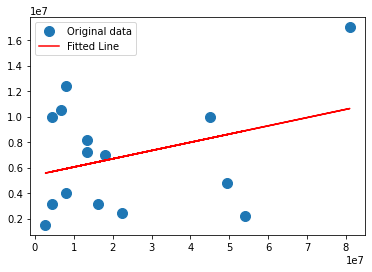

attr1


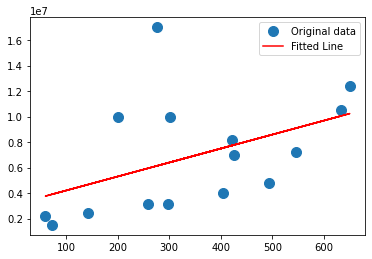

attr2


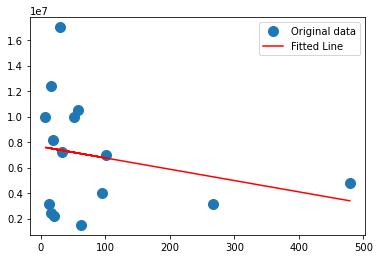

attr3


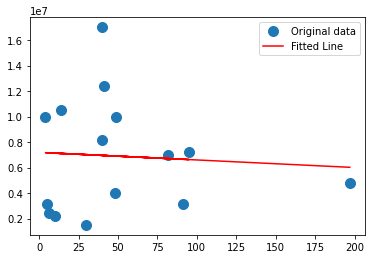

attr4


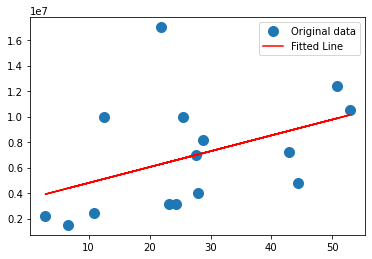

age


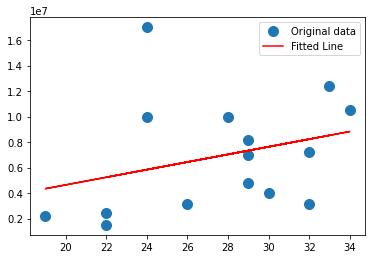

In [378]:
# simple regression with one parameter
y = df2["salary"]
y = pd.to_numeric(y, errors ="coerce")
cm = 1/2.54
for i in ['value', 'attr1', 'attr2','attr3', 'attr4','age']:
    print(i)
    x = df2[i]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A,y, rcond =None)[0]
    _ = plt.plot(x,y,"o", label = "Original data", markersize =10)
    _ = plt.plot(x, m*x+c, "r", label = "Fitted Line")
    _ = plt.legend()
    plt.show()
#looks not very promising

In [368]:
# regression with multiple parameters
df3 = df2[["position","salary",'value', 'attr1', 'attr2','attr3', 'attr4','age']]
df4 = pd.concat((
     df3,
     pd.get_dummies(df3['position'], drop_first=False)), axis=1)
df4= df4.drop(columns = "position")
for col in df4.columns:
    if df4[col].dtypes != "uint8":
        df4[col] = pd.to_numeric(df3[col], errors ="coerce")
model = smf.ols(formula = "salary ~ value + attr1 + attr2 + attr3 + attr4 + age + goalkeeper + defender + midfield + attack",data= df4)
results = model.fit()
results.params

Intercept    -1.306026e+07
value         1.285399e-01
attr1        -5.922850e+04
attr2        -2.614580e+04
attr3         1.036189e+04
attr4         6.853679e+05
age           8.710396e+05
goalkeeper   -5.057844e+06
defender     -4.988392e+06
midfield     -5.246692e+03
attack       -3.008781e+06
dtype: float64

In [369]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
df5 = rows_with_NaN[["position",'value', 'attr1', 'attr2','attr3', 'attr4','age']]
df5 = pd.concat((
     df5,
     pd.get_dummies(df5['position'], drop_first=False)), axis=1)
df5= df5.drop(columns = "position")
df5["goalkeeper"] = 0
for col in df5.columns:
    if df5[col].dtypes != "uint8":
        df5[col] = pd.to_numeric(df5[col], errors ="coerce")
results.predict(df5)

4     1.180391e+06
6     1.565751e+06
10             NaN
11    2.074247e+06
12    1.524635e+06
13    1.354173e+07
15    3.468828e+06
17    1.174631e+07
18             NaN
19    5.805422e+06
24   -9.830679e+05
25    2.675331e+06
26    5.146680e+06
27   -6.406237e+05
29    2.673044e+06
dtype: float64

In [370]:
df5 = rows_with_NaN[["position",'value', 'attr1', 'attr2','attr3', 'attr4','age']]
df5 = pd.concat((
     df5,
     pd.get_dummies(df5['position'], drop_first=False)), axis=1)

In [371]:
from sklearn.tree import DecisionTreeRegressor
y = df2["salary"]
y = pd.to_numeric(y, errors ="coerce")
x = df2["value"]
A = np.vstack([x, np.ones(len(x))]).T
DT_model = DecisionTreeRegressor(max_depth=5).fit(A,y)

In [372]:
#regression with decision tree and only "value"
y = df2["salary"]
y = pd.to_numeric(y, errors ="coerce")
x = df2["value"]
A = np.vstack([x, np.ones(len(x))]).T
DT_model = DecisionTreeRegressor().fit(A,y)
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
x2 = rows_with_NaN["value"]
A2 = np.vstack([x2, np.ones(len(x2))]).T
DT_model.predict(A2)
rows_with_NaN["salary"] = DT_model.predict(A2)
rows_with_NaN["salary"]

<ipython-input-372-6482e4918ac5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_NaN["salary"] = DT_model.predict(A2)


4      7000000.0
6      7680000.0
10     6560000.0
11     2400000.0
12     1500000.0
13     1500000.0
15    10500000.0
17    17000000.0
18     2400000.0
19     7680000.0
24     8200000.0
25     1500000.0
26    10000000.0
27     7680000.0
29    10500000.0
Name: salary, dtype: float64

In [373]:
#predict with decision tree and multiple values
y = df2["salary"]
y = pd.to_numeric(y, errors ="coerce")
df3 = df2[["position",'value', 'attr1', 'attr2','attr3', 'attr4','age']]
df4 = pd.concat((
     df3,
     pd.get_dummies(df3['position'], drop_first=False)), axis=1)
df4= df4.drop(columns = "position")
for col in df4.columns:
    if df4[col].dtypes != "uint8":
        df4[col] = pd.to_numeric(df3[col], errors ="coerce")
x = df4
A = sm.add_constant(x)
DT_model = DecisionTreeRegressor().fit(A,y)
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
df3 = rows_with_NaN[["position",'value', 'attr1', 'attr2','attr3', 'attr4','age']]
df4 = pd.concat((
     df3,
     pd.get_dummies(df3['position'], drop_first=False)), axis=1)
df4= df4.drop(columns = "position")
for col in df4.columns:
    if df4[col].dtypes != "uint8":
        df4[col] = pd.to_numeric(df3[col], errors ="coerce")
x2 = df4
A2 = sm.add_constant(x2)
A2["goalkeeper"] = 0
DT_model.predict(A2.dropna())
DT_model.predict(A2.dropna())

array([ 2400000.,  2400000.,  2400000.,  1500000., 10500000.,  1500000.,
       17000000.,  2400000.,  1500000.,  1500000.,  4000000., 12400000.,
        4800000.])

,name,age,position,nation,value,attr1,attr2,attr3,attr4,salary,team
id,,,,,,,,,,,
0,Marc-André ter Stegen,29,goalkeeper,germany,40500000,501,489.0,198,45.019,4800000,fc barcelona
1,Neto,32,goalkeeper,brazil,3600000,259,268.0,91,23.318,3120000,fc barcelona
2,Iñaki Peña,22,goalkeeper,spain,2700000,73,65.0,30,6.630,1500000,fc barcelona
3,Ronald Araújo,22,defender,uruguay,31500000,149,16.0,6,11.503,2400000,fc barcelona
4,Eric García,21,defender,spain,16200000,105,6.0,2,8.499,NaN,fc barcelona
5,Clément Lenglet,26,defender,france,12600000,304,13.0,6,24.711,3120000,fc barcelona
6,Óscar Mingueza,22,defender,spain,8100000,113,2.0,9,7.759,NaN,fc barcelona
7,Gerard Piqué,34,defender,spain,4500000,640,57.0,14,53.375,10500000,fc barcelona
8,Samuel Umtiti,28,defender,france,1800000,303,7.0,4,25.639,10000000,fc barcelona


In [55]:
list1 = ["age","value","attr1","attr2","attr3","attr4","salary"]
avg = []*(len(list1))
i=0
for column in list1:
    i= i+1
    avg.append(df[column].sum()/len(df))
result = pd.DataFrame({"Values": list1, "Averages": avg})

In [57]:
#absoulte values
df.iloc[16][list1] - avg


age             -0.8
value     4.4385e+07
attr1        27.3667
attr2       -26.4667
attr3       0.866667
attr4         2.7881
salary    1.3788e+07
Name: 16, dtype: object